In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler, LabelEncoder, OrdinalEncoder
from sklearn import neighbors

# Data set

In [2]:
data = pd.read_csv("iris_dataset.csv")
data.head()

,sepallength,sepalwidth,petallength,petalwidth,class
0,5.1,3.5,1.4,0.2,Iris-setosa
1,4.9,3.0,1.4,0.2,Iris-setosa
2,4.7,3.2,1.3,0.2,Iris-setosa
3,4.6,3.1,1.5,0.2,Iris-setosa
4,5.0,3.6,1.4,0.2,Iris-setosa


In [3]:
# split data into training and test set
X = data.iloc[:, :-1]
y = data.iloc[:, -1:]

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=30)

# Exploration

## Overview

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150 entries, 0 to 149
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   sepallength  150 non-null    float64
 1   sepalwidth   150 non-null    float64
 2   petallength  150 non-null    float64
 3   petalwidth   150 non-null    float64
 4   class        150 non-null    object 
dtypes: float64(4), object(1)
memory usage: 6.0+ KB


In [5]:
data.isnull().sum()

sepallength    0
sepalwidth     0
petallength    0
petalwidth     0
class          0
dtype: int64

In [6]:
data.describe()

,sepallength,sepalwidth,petallength,petalwidth
count,150.000000,150.000000,150.000000,150.000000
mean,5.843333,3.054000,3.758667,1.198667
std,0.828066,0.433594,1.764420,0.763161
min,4.300000,2.000000,1.000000,0.100000
25%,5.100000,2.800000,1.600000,0.300000
50%,5.800000,3.000000,4.350000,1.300000
75%,6.400000,3.300000,5.100000,1.800000
max,7.900000,4.400000,6.900000,2.500000


In [7]:
corr = data.corr()
corr

,sepallength,sepalwidth,petallength,petalwidth
sepallength,1.000000,-0.109369,0.871754,0.817954
sepalwidth,-0.109369,1.000000,-0.420516,-0.356544
petallength,0.871754,-0.420516,1.000000,0.962757
petalwidth,0.817954,-0.356544,0.962757,1.000000


## Plots

<AxesSubplot:>

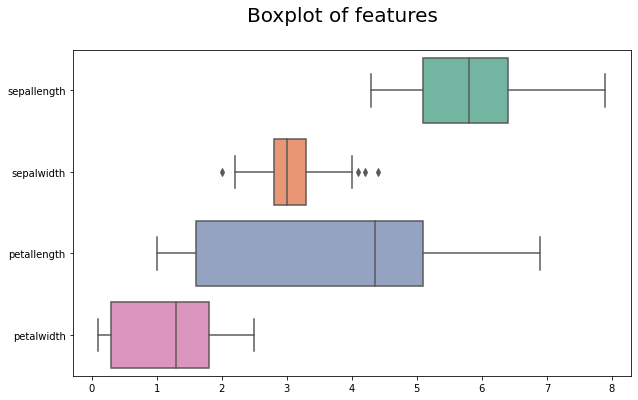

In [8]:
fig, axs = fig, axs = plt.subplots(figsize=(10, 6))
fig.suptitle("Boxplot of features", fontsize=20)
sns.boxplot(data=X, orient="h", palette="Set2")

<AxesSubplot:>

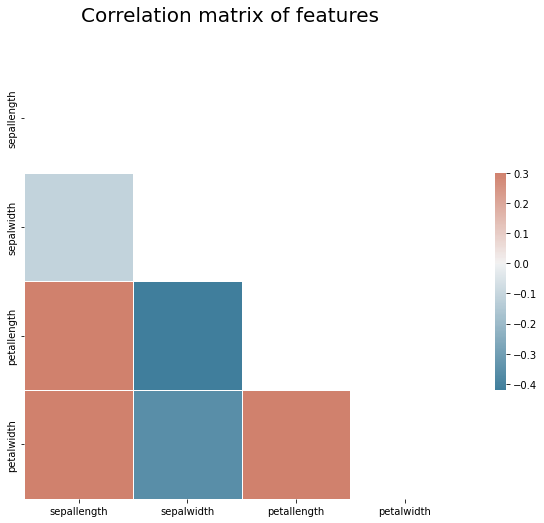

In [9]:
mask = np.triu(np.ones_like(corr, dtype=bool))
fig, axs = plt.subplots(figsize=(13, 8))
fig.suptitle("Correlation matrix of features", fontsize=20)
cmap = sns.diverging_palette(230, 20, as_cmap=True)
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

<AxesSubplot:xlabel='class', ylabel='petalwidth'>

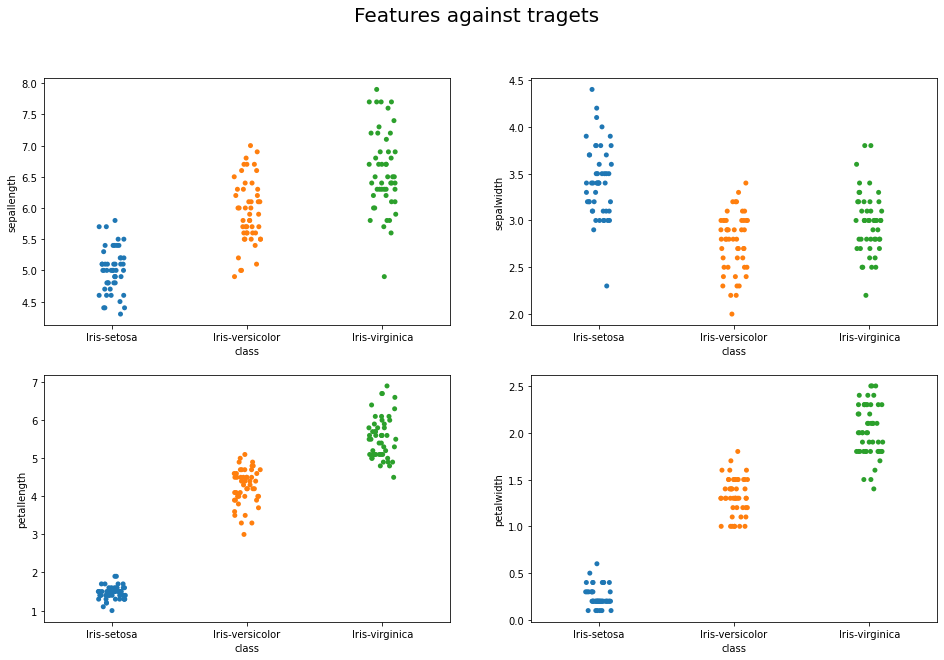

In [10]:
fig, axs = plt.subplots(2, 2, figsize=(16,10))
fig.suptitle("Features against targets", fontsize=20)
sns.stripplot(data=data, x="class", y="sepallength", ax=axs[0, 0])
sns.stripplot(data=data, x="class", y="sepalwidth", ax=axs[0, 1])
sns.stripplot(data=data, x="class", y="petallength", ax=axs[1, 0])
sns.stripplot(data=data, x="class", y="petalwidth", ax=axs[1, 1])

# Pre-processing

## Feature selection

## Feature Scaling

In [11]:
scaler = StandardScaler().fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

## Encoding

In [12]:
enc = LabelEncoder()
y_train_encoded = enc.fit_transform(y_train.values.ravel())
y_test_encoded = enc.fit_transform(y_test.values.ravel())

# Model selection and performance measures

In [13]:
# K-NN
knn_classifiers = {
    "KNN [1, uniform]": neighbors.KNeighborsClassifier(n_neighbors=1),
    "KNN [1, distance]": neighbors.KNeighborsClassifier(n_neighbors=1, weights="distance"),
    "KNN [3, uniform]": neighbors.KNeighborsClassifier(n_neighbors=3),
    "KNN [3, distance]": neighbors.KNeighborsClassifier(n_neighbors=3, weights="distance"),
    "KNN [5, uniform]": neighbors.KNeighborsClassifier(n_neighbors=5),
    "KNN [5, distance]": neighbors.KNeighborsClassifier(n_neighbors=5, weights="distance"),
    "KNN [10, uniform]": neighbors.KNeighborsClassifier(n_neighbors=10),
    "KNN [10, distance]": neighbors.KNeighborsClassifier(n_neighbors=10, weights="distance"),
    "KNN [15, uniform]": neighbors.KNeighborsClassifier(n_neighbors=15),
    "KNN [15, distance]": neighbors.KNeighborsClassifier(n_neighbors=15, weights="distance"),
    "KNN [20, uniform]": neighbors.KNeighborsClassifier(n_neighbors=20),
    "KNN [20, distance]": neighbors.KNeighborsClassifier(n_neighbors=20, weights="distance")
}


In [14]:
# Decision tree

In [15]:
# Random forest

In [16]:
# Support Vector Machines

In [17]:
# Performance measures: Accuracy, Confusion matrix, F1-Score, Cross-entropy, Recall (only binary)

# Training and validation

In [18]:
knn = neighbors.KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train_scaled, y_train_encoded)
y_pred = knn.predict(X_test_scaled)

print(y_pred)
print(y_test_encoded)

[0 0 0 2 1 1 2 2 1 2 0 2 1 1 0 1 0 0 0 1 1 0 0 0 2 2 1 2 0 1 2 1 2 2 2 2 1
 2]
[0 0 0 2 1 1 2 2 1 2 0 2 1 1 0 1 0 0 0 1 2 0 0 0 2 2 1 2 0 1 2 1 2 2 2 2 1
 2]


In [19]:
# Performance measures


In [20]:
# Holdout


In [21]:
# Cross-validation


# Results

In [22]:
# Performance measures


In [23]:
# Significance tests against baseline (DummyClassifier)
